In [1]:
import os
import pandas as pd
import numpy as np
import sklearn

In [2]:
root_path = os.getcwd()
data_path = root_path + '/data/exoplanets.csv'

In [3]:
df = pd.read_csv(data_path)
df.head()

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


In [4]:
df.shape

(9564, 49)

# Preprocessing

First let's take a look at missing values in our columns

In [5]:
missing_values = df.isna().sum() / len(df) * 100
missing_values.sort_values(ascending=False)[:10]

koi_teq_err2      100.000000
koi_teq_err1      100.000000
kepler_name        75.334588
koi_score          15.788373
koi_steff_err2      5.050188
koi_srad_err2       4.893350
koi_srad_err1       4.893350
koi_slogg_err2      4.893350
koi_slogg_err1      4.893350
koi_steff_err1      4.893350
dtype: float64

We decide we will drop those columns with more than 20% of missing values. As for the other, they will be imputed.

In [6]:
df = df.drop(columns={'koi_teq_err2','koi_teq_err1','kepler_name'})
df.columns

Index(['kepid', 'kepoi_name', 'koi_disposition', 'koi_pdisposition',
       'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co',
       'koi_fpflag_ec', 'koi_period', 'koi_period_err1', 'koi_period_err2',
       'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact',
       'koi_impact_err1', 'koi_impact_err2', 'koi_duration',
       'koi_duration_err1', 'koi_duration_err2', 'koi_depth', 'koi_depth_err1',
       'koi_depth_err2', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2',
       'koi_teq', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2',
       'koi_model_snr', 'koi_tce_plnt_num', 'koi_tce_delivname', 'koi_steff',
       'koi_steff_err1', 'koi_steff_err2', 'koi_slogg', 'koi_slogg_err1',
       'koi_slogg_err2', 'koi_srad', 'koi_srad_err1', 'koi_srad_err2', 'ra',
       'dec', 'koi_kepmag'],
      dtype='object')

We separate the dataset into two subsets, one for numerical features and the other for categorical features. Note that we are keeping the index in both in order to merge them afterwards. 

In [7]:
numerical_columns = []
categorical_columns = []

for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
        numerical_columns.append(column)
    else:
        categorical_columns.append(column)
categorical_columns.append('kepid')

df_num = df[numerical_columns]
df_cat = df[categorical_columns]

df_num.shape, df_cat.shape

((9564, 42), (9564, 5))

In [8]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)
df_filled_num = pd.DataFrame(imputer.fit_transform(df_num),columns=df_num.columns)

In [9]:
df_filled_num.isna().sum().sum()

0

In [10]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')
df_filled_cat = pd.DataFrame(imputer.fit_transform(df_cat),columns=df_cat.columns)

In [11]:
df_filled_cat.isna().sum().sum()

0

In [12]:
df = pd.merge(df_filled_num,df_filled_cat,on='kepid')
df['kepid'] = df['kepid'].astype(int)
df.shape

(13450, 46)

In [13]:
df.head()

,kepid,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,...,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag,kepoi_name,koi_disposition,koi_pdisposition,koi_tce_delivname
0,10797460,1.000,0.0,0.0,0.0,0.0,9.488036,0.000028,-0.000028,170.538750,...,0.927,0.105,-0.061,291.93423,48.141651,15.347,K00752.01,CONFIRMED,CANDIDATE,q1_q17_dr25_tce
1,10797460,1.000,0.0,0.0,0.0,0.0,9.488036,0.000028,-0.000028,170.538750,...,0.927,0.105,-0.061,291.93423,48.141651,15.347,K00752.02,CONFIRMED,CANDIDATE,q1_q17_dr25_tce
2,10797460,0.969,0.0,0.0,0.0,0.0,54.418383,0.000248,-0.000248,162.513840,...,0.927,0.105,-0.061,291.93423,48.141651,15.347,K00752.01,CONFIRMED,CANDIDATE,q1_q17_dr25_tce
3,10797460,0.969,0.0,0.0,0.0,0.0,54.418383,0.000248,-0.000248,162.513840,...,0.927,0.105,-0.061,291.93423,48.141651,15.347,K00752.02,CONFIRMED,CANDIDATE,q1_q17_dr25_tce
4,10811496,0.000,0.0,0.0,0.0,0.0,19.899140,0.000015,-0.000015,175.850252,...,0.868,0.233,-0.078,297.00482,48.134129,15.436,K00753.01,CANDIDATE,CANDIDATE,q1_q17_dr25_tce


# EDA

First let's look at our numerical variables

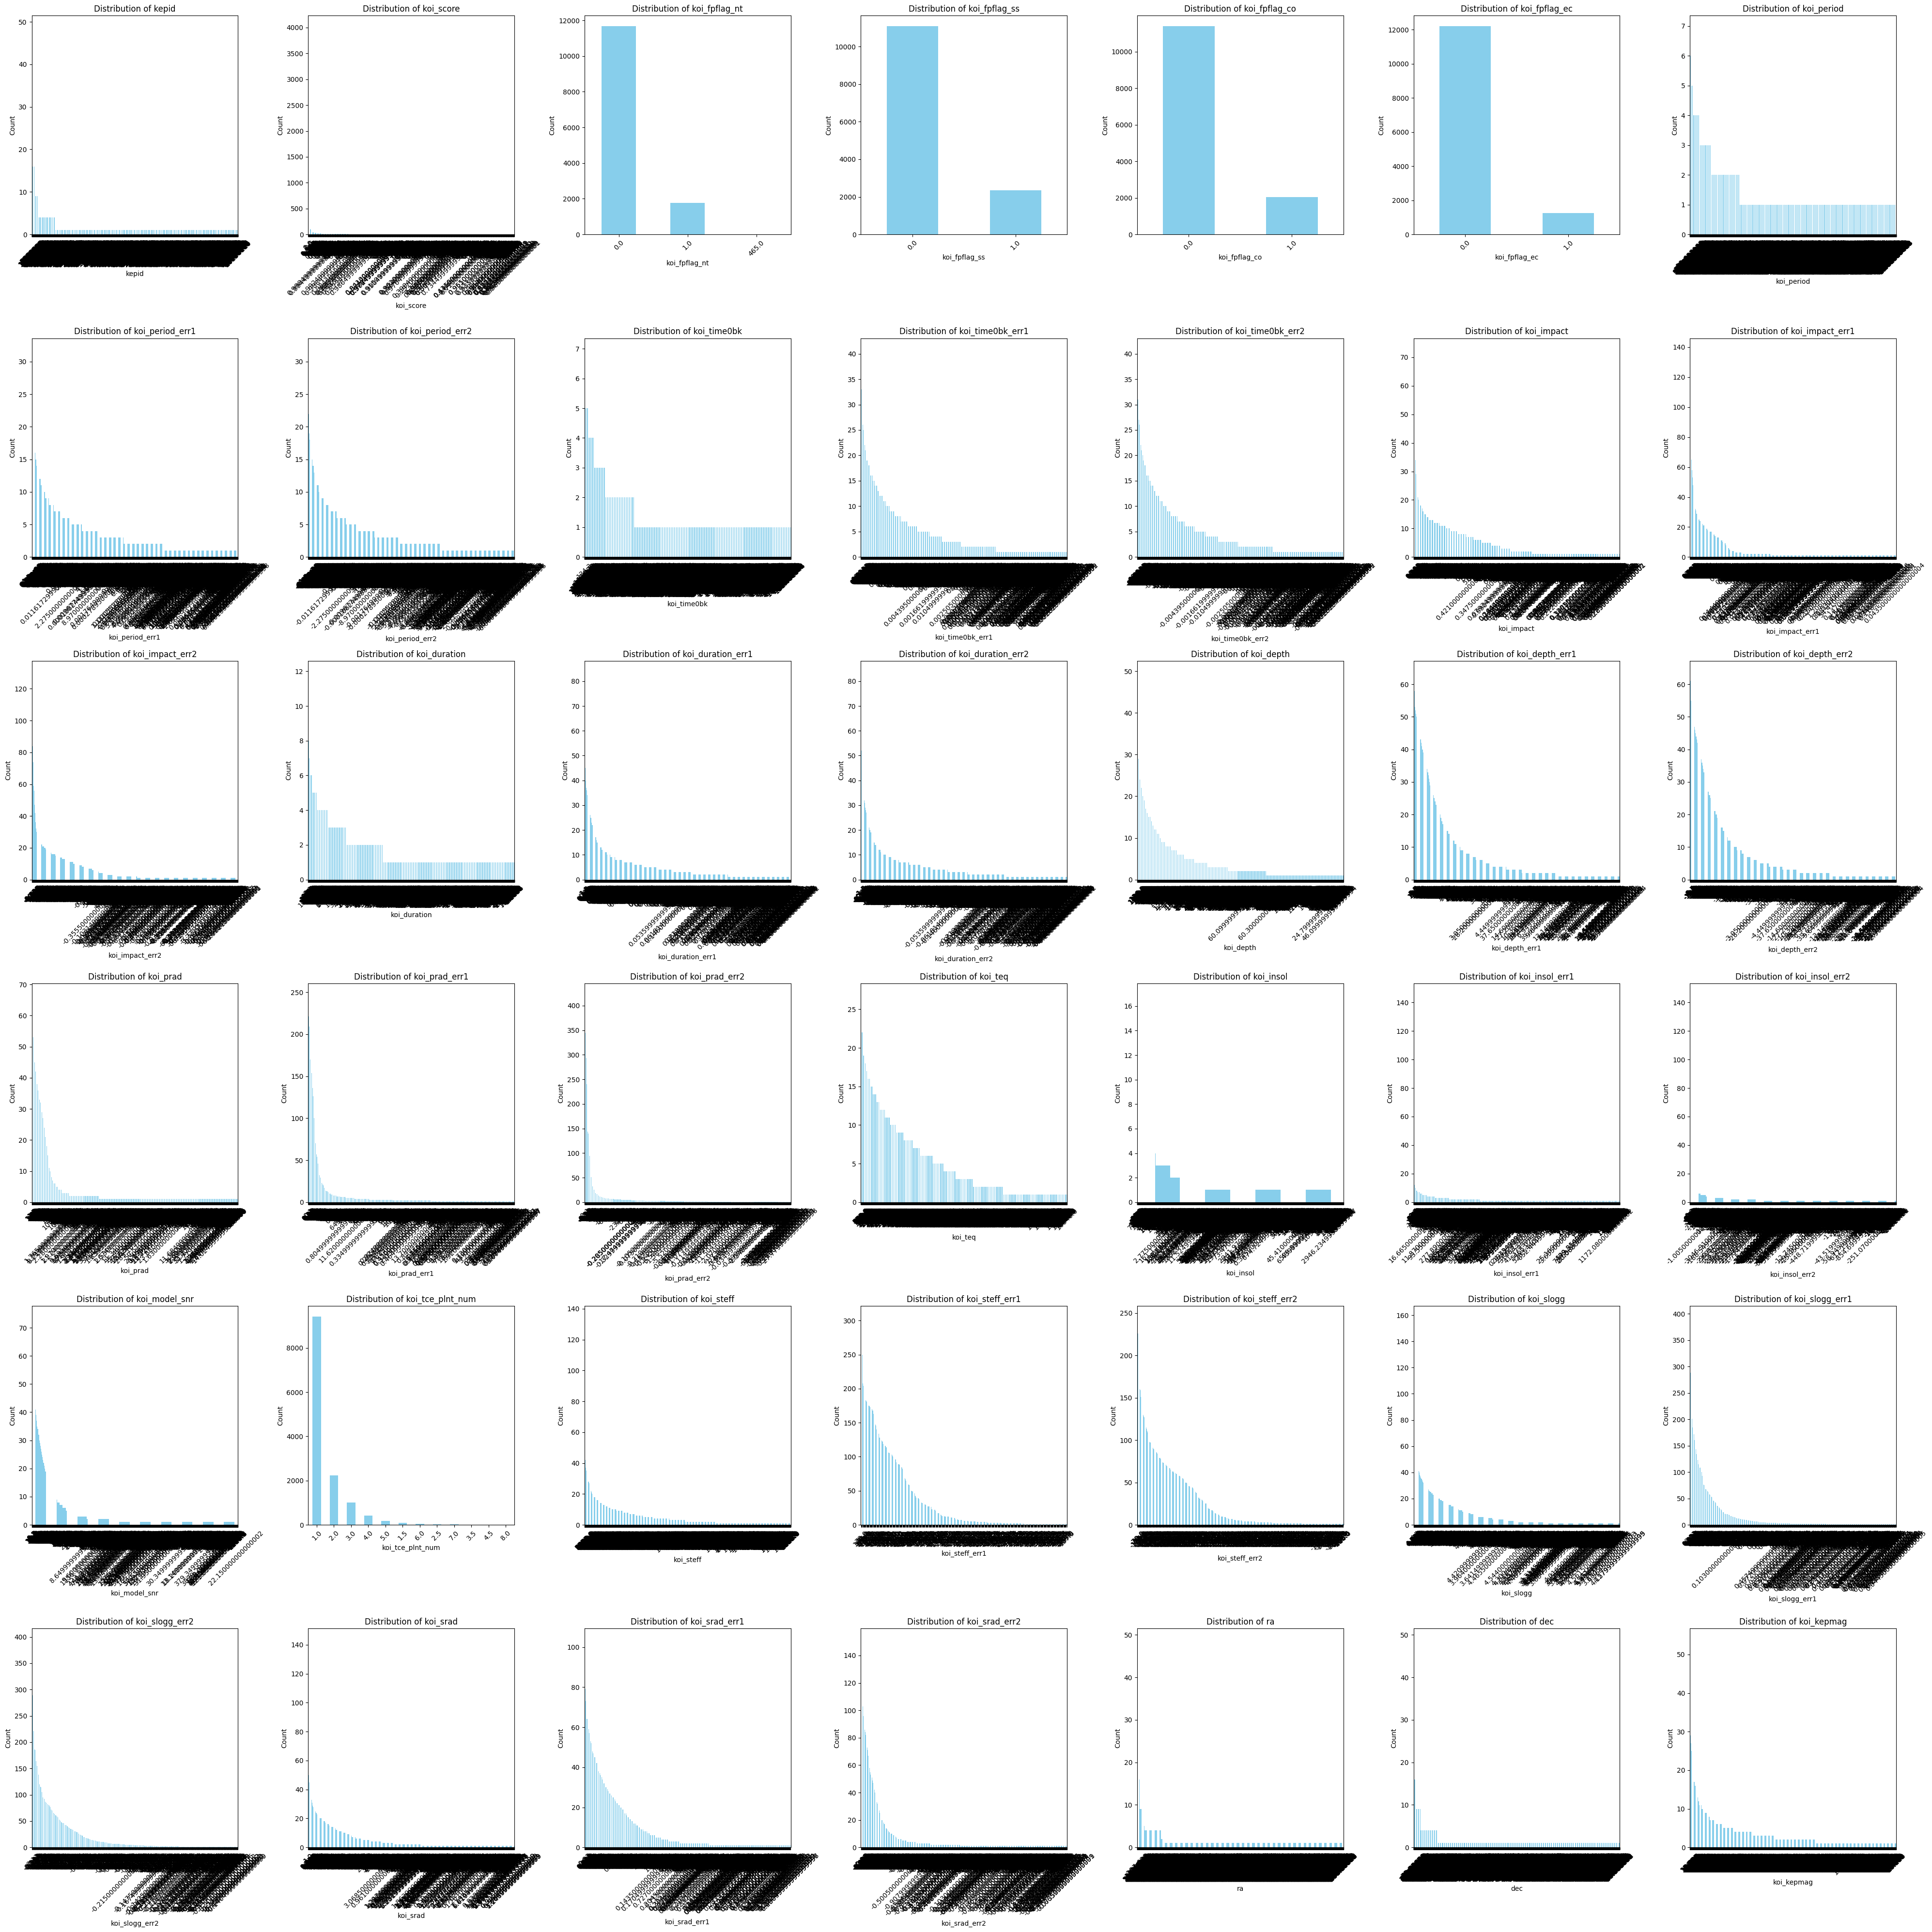

In [17]:
import matplotlib.pyplot as plt
df_num = df.select_dtypes(include=['number'])

#fig, axes = plt.subplots(nrows=9, ncols=5, figsize=(15, 5))
'''fig, axes = plt.subplots(nrows=1, ncols=len(df_num.columns), figsize=(15, 5))

for i, column in enumerate(df_num.columns):
    df_num[column].value_counts().plot(kind='bar', ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)'''

num_cols = len(df_num.columns)

# Calculate the number of rows and columns for the subplots
num_rows = int(num_cols**0.5)
num_cols = (num_cols // num_rows) + (num_cols % num_rows)

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(40, 40))

# Flatten axes array if needed
if num_rows == 1 or num_cols == 1:
    axes = axes.flatten()
else:
    axes = axes.reshape(-1)

for i, column in enumerate(df_num.columns):
    df_num[column].value_counts().plot(kind='bar', ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

# Hide any empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# PCA and Clustering

To continue the exploration, we will perform PCA and clustering.

In [18]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

##  PCA

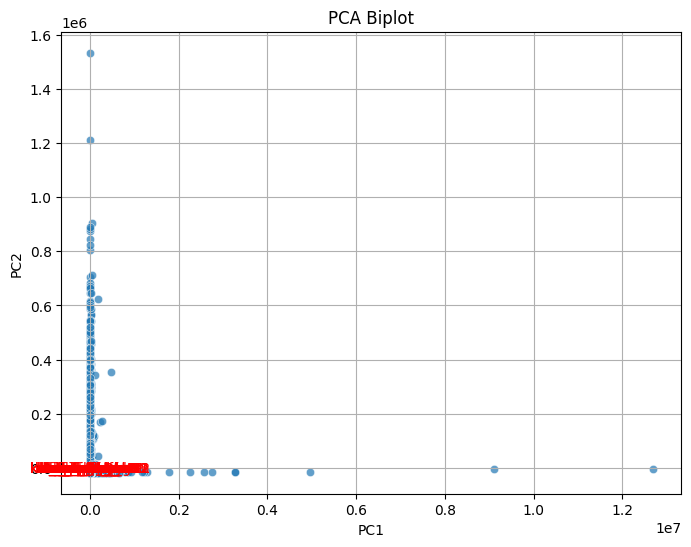

In [23]:
df_num = df.select_dtypes(include=['number'])
df_num = df_num.drop(columns=['kepid'])

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_num)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

norms = np.linalg.norm(loadings, axis=1)
loadings_scaled = loadings / np.max(norms)

# Creating a biplot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], alpha=0.7)

# Plotting variable loadings as arrows on the biplot
for i, feature in enumerate(df_num.columns):
    plt.arrow(0, 0, loadings_scaled[i, 0], loadings_scaled[i, 1], color='r', alpha=0.5)
    plt.text(loadings_scaled[i, 0]*1.15, loadings_scaled[i, 1]*1.15, feature, color='r', ha='center', va='center')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Biplot')
plt.grid(True)
plt.show()

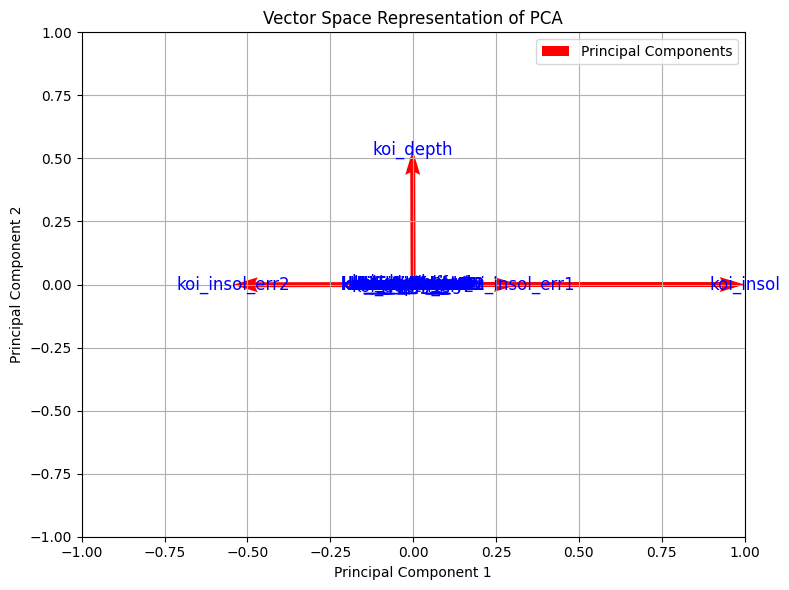

In [24]:
plt.figure(figsize=(8, 6))

norms = np.linalg.norm(loadings, axis=1)

# Normalize the vectors
loadings_scaled = loadings / np.max(norms)

# Plot the principal components as vectors
plt.quiver(np.zeros_like(loadings_scaled[:, 0]), np.zeros_like(loadings_scaled[:, 1]),
           loadings_scaled[:, 0], loadings_scaled[:, 1],
           angles='xy', scale_units='xy', scale=1, color='r', label='Principal Components')

# Setting limits
plt.xlim(-1, 1)
plt.ylim(-1, 1)

# Adding feature names
for i, feature in enumerate(df_num.columns):
    plt.text(loadings_scaled[i, 0], loadings_scaled[i, 1], feature, color='b', fontsize=12, ha='center', va='center')

# Adding labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Vector Space Representation of PCA')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

Looking at the biplot and...

## Clustering

In [32]:
num_clusters = 3
df_num = df.select_dtypes(include=['number'])

kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(df_num)

cl_centers = kmeans.cluster_centers_
labels = kmeans.labels_

df['Cluster'] = labels
df['Cluster'].value_counts()

Cluster
0    4787
1    4764
2    3899
Name: count, dtype: int64

We visualize it in the PCA subspace

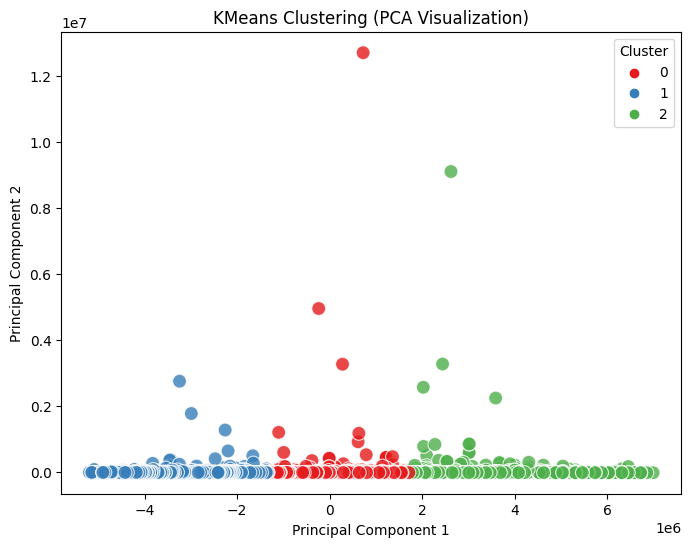

In [34]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_num)

# Creating a DataFrame from PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['Cluster'] = df['Cluster']

# Visualizing the clusters in 2D using PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set1', s=100, alpha=0.8)
plt.title('KMeans Clustering (PCA Visualization)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

# Feature Selection